In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pickle
import h5py

In [2]:
import tensorflow as tf
#tf.config.set_visible_devices([], 'GPU')
from tensorflow.keras.layers import Conv1D, Dense, LeakyReLU, concatenate, Input, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%run util
%run main_model
%run elasticity_funcs

# Load Data

In [4]:
baskets = pd.read_parquet("data/baskets.parquet")
baskets["week"] = baskets["week"].astype("uint8")
baskets["shopper"] = baskets["shopper"].astype("int32")
baskets["product"] = baskets["product"].astype("uint8")
baskets["price"] = baskets["price"].astype("uint16")
# Add a label to simplify densification later-on
baskets["bought"] = 1
baskets["bought"] = baskets["bought"].astype("uint8")
baskets.head()

,week,shopper,product,price,bought
0,0,0,71,629,1
1,0,0,91,605,1
2,0,0,116,715,1
3,0,0,123,483,1
4,0,0,157,592,1


In [5]:
coupons = pd.read_parquet("data/coupons.parquet")
coupons["week"] = coupons["week"].astype("uint8")
coupons["shopper"] = coupons["shopper"].astype("int32")
coupons["product"] = coupons["product"].astype("uint8")
coupons["discount"] = coupons["discount"].astype("uint8")
coupons.head()

,week,shopper,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30


---
Create an index connecting a product to its unreduced price

In [7]:
price_index = baskets.groupby("product").price.apply(max).reset_index()
price_index.to_parquet("data/price_index.parquet")

In [132]:
price_index = pd.read_parquet("data/price_index.parquet")

# Load Preprocessed Data

In [6]:
first_x = 100000  # First x shoppers to consider

Multi-core preprocessing that will transform the data to make it compatible with the model:
- First keyword is number of shoppers
- Second keyword is core count

Result will be pickled into working directory (100,000 customers will result in 4GB of data)

Running the script in command line will display a progress bar.

In [7]:
# !python mp_preprocessing.py first_x 10

In [9]:
with open(f'./data/histories_first_{first_x}.pkl', 'rb') as file_name:
    prep_histories = pickle.load(file_name)

with open(f'./data/coupons_first_{first_x}.pkl', 'rb') as file_name:
    prep_coupons = pickle.load(file_name)

# Evaluate model: 

## Hold-out validation

In [10]:
# From util.py
# Model building, weight initalization and elasticity calculation is carried out behind the covers

model = iterate_epochs(prep_histories, 
                       prep_coupons,
                       model=None,
                       weeks_to_validate=10,
                       max_epochs=30,
                       H=40,
                       L=50,
                       validate_every=30,
                       shoppers_for_scoring=10000,
                       batch_size=32,
                       learning_rate=0.001,
                       calculate_elasticities=True,
                       verbose=1)


Training on weeks 0 to 78 with labels of week 79...

Epoch 1
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0891 - auc_3: 0.9207
Epoch 2
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0805 - auc_3: 0.9423
Epoch 3
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0794 - auc_3: 0.9440
Epoch 4
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0788 - auc_3: 0.9449
Epoch 5
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0783 - auc_3: 0.9455
Epoch 6
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0780 - auc_3: 0.9461
Epoch 7
3125/3125 [==============================] - 11s 3ms/step - loss: 0.0777 - auc_3: 0.9465
Epoch 8
3125/3125 [==============================] - 11s 3ms/step - loss: 0.0774 - auc_3: 0.9469
Epoch 9
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0771 - auc_3: 0.9472
Epoch 10
3125/3125 [==============================] - 11s 3ms/step - loss

## Apply T-SNE to Bottleneck Weight Matrix

In [33]:
for ix, l in enumerate(model.layers):
    print(ix, l.name)

0 hists
1 coups
2 conv1d_3
3 leaky_re_lu_1
4 freqs
5 tf_op_layer_Mul_3
6 Transpose_B_H
7 Transpose_B_inf
8 Transpose_D
9 W_IN_B_H
10 W_IN_B_inf
11 W_IN_D
12 tf_op_layer_Shape_1
13 W_OUT_B_H
14 W_OUT_B_inf
15 W_OUT_D
16 tf_op_layer_Fill_1
17 Transpose_B_H_bar_back
18 Transpose_B_inf_bar_back
19 Transpose_D_bar_back
20 concatenate_1
21 Sigmoid


In [77]:
W_IN = model.layers[9].get_weights()[0]

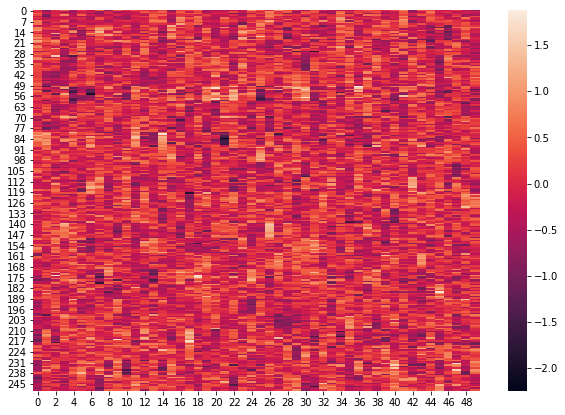

In [78]:
plt.figure(figsize=(10,7))
sns.heatmap(W_IN);

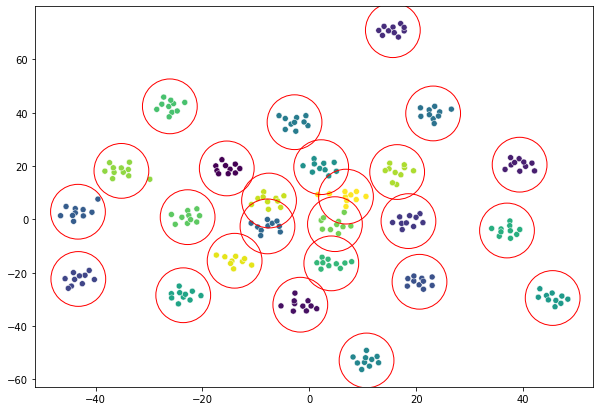

In [79]:
tsne = TSNE(n_components=2,
            perplexity=10,
            n_iter=10000,
            verbose=0,
            learning_rate=10,
            random_state=69,
            angle=0.5,
            n_jobs=6)

kmeans = KMeans(n_clusters=25,
                n_init=10,
                max_iter=300,
                verbose=1,
                random_state=420,
                copy_x=True,
                n_jobs=6)

tsne_df = tsne.fit_transform(W_IN)
kmeans.fit(tsne_df)
kmpred = kmeans.predict(tsne_df)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10,7))
sns.scatterplot(x=tsne_df[:, 0], y=tsne_df[:, 1], hue=kmpred, palette="viridis", legend=None)
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], marker="o", s=3000, facecolors='none', edgecolors="red");

In [80]:
kmpred

array([21, 21, 21, 21, 21, 21, 21, 21, 21, 21,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5, 23, 23, 23, 23, 23, 23, 23, 20, 23, 23, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 22,
       22, 22, 22, 22, 22

# Select Coupons

In [10]:
J = 250
T = 89  # Weeks 0 to 88 ... have to omit 89 from training because there are no t+1 buys or coupons
H = 40  # Number of convolutional filters over history
L = 50  # Encoding dimension
# K (width of concatenate layer) should be H + H + 2 + 2 + 1

In [11]:
model = build_model(J, T, H, L)

In [27]:
histories_x_train = prep_histories[:, :, :T]
coupons_x_train = prep_coupons[:, :, T].reshape((prep_coupons.shape[0], 250, 1))
y_train = prep_histories[:, :, T].reshape((prep_histories.shape[0], 250, 1))

In [28]:
#history = model.fit([histories_x_train, coupons_x_train], y_train, epochs=30, verbose=1, batch_size=32, validation_split=0)

Epoch 1/30
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0889 - auc: 0.9214
Epoch 2/30
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0803 - auc: 0.9431
Epoch 3/30
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0794 - auc: 0.9447
Epoch 4/30
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0788 - auc: 0.9456
Epoch 5/30
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0783 - auc: 0.9464
Epoch 6/30
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0780 - auc: 0.9469
Epoch 7/30
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0777 - auc: 0.9472
Epoch 8/30
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0774 - auc: 0.9476
Epoch 9/30
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0772 - auc: 0.9480
Epoch 10/30
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0770 - auc: 0.9482
Epoch 11/30
3125/31

In [29]:
#model.save_weights("./saved_weights/main_model_full")

In [12]:
model.load_weights("./saved_weights/main_model_full");

In [45]:
coupon_index = pd.read_parquet("data/coupon_index.parquet")
coupon_index["product"] = -1
coupon_index["discount"] = -1

In [47]:
for shopper in tqdm(range(2000)):
    # From util.py
    optimal_coupons = optimize_coupons_by_cat(shopper, model, prep_histories[:, :, 1:90], kmpred, verbose=False)
    optimal_products = np.where(optimal_coupons > 0)[0]
    optimal_discounts = optimal_coupons[optimal_products]
    coupon_index.loc[coupon_index["shopper"]==shopper, "product"] = optimal_products
    coupon_index.loc[coupon_index["shopper"]==shopper, "discount"] = optimal_discounts
    
coupon_index["discount"] = coupon_index["discount"].astype("uint8")

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [16:45<00:00,  1.99it/s]


In [71]:
coupon_index

,week,shopper,coupon,product,discount
0,90,0,0,11,30
2000,90,0,1,29,30
4000,90,0,2,64,30
6000,90,0,3,191,30
8000,90,0,4,243,30
...,...,...,...,...,...
1999,90,1999,0,4,30
3999,90,1999,1,10,30
5999,90,1999,2,164,30
7999,90,1999,3,172,30


In [50]:
coupon_index.to_parquet("../coupon_index.parquet")